In [1]:
import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random, torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.5)

In [2]:
import sys

sys.path.insert(0,  '/home/was966/Research/mims-conceptor/')
from conceptor.utils import plot_embed_with_label
from conceptor import PreTrainer, FineTuner, loadconceptor #, get_minmal_epoch
from conceptor.utils import plot_embed_with_label, plot_performance, score2
from conceptor.tokenizer import CANCER_CODE
def onehot(S):
    assert type(S) == pd.Series, 'Input type should be pd.Series'
    dfd = pd.get_dummies(S, dummy_na=True)
    nanidx = dfd[dfd[np.nan].astype(bool)].index
    dfd.loc[nanidx, :] = np.nan
    dfd = dfd.drop(columns=[np.nan])*1.
    cols = dfd.sum().sort_values(ascending=False).index.tolist()
    dfd = dfd[cols]
    return dfd

In [3]:
from conceptor.tokenizer import CONCEPT_palette

In [4]:
import shap
import torch
import torch.nn as nn
from shap import DeepExplainer
torch.manual_seed(0)

In [5]:
shap.__version__, np.__version__

('0.44.1', '1.24.3')

In [6]:
## load pretrainer
mfile = '/home/was966/Research/mims-conceptor/paper/checkpoint/latest/pretrainer.pt'
pretrainer = loadconceptor(mfile)

## read data
df_label = pd.read_pickle('/home/was966/Research/mims-conceptor/paper//00_data/ITRP.PATIENT.TABLE')
df_tpm = pd.read_pickle('/home/was966/Research/mims-conceptor/paper//00_data/ITRP.TPM.TABLE')
df_tpm.shape, df_label.shape

((1133, 15672), (1133, 110))

In [7]:
s = df_label.groupby('cohort').size()
cohorts = ['IMVigor210']

cohort_name = '_'.join(cohorts)
df_label = df_label[df_label.cohort.isin(cohorts)]

cancer_type = '_'.join(df_label.cancer_type.unique())
cohort_name = cancer_type + ':' + cohort_name

df_tpm = df_tpm.loc[df_label.index]
dfcx = df_label.cancer_type.map(CANCER_CODE).to_frame('cancer_code').join(df_tpm)
df_task = onehot(df_label.response_label)

In [8]:
finetuner = loadconceptor('./finetuner.pt', map_location='cpu')
device = finetuner.device

dfg, dfc = finetuner.extract(dfcx)
_, dfy = finetuner.predict(dfcx)

model = finetuner.model.taskdecoder
# model.eval()

fname = dfc.columns[:-1]
x = torch.tensor(dfc[fname].values).to(device)

100%|##########| 1/1 [00:39<00:00, 39.65s/it]


In [9]:
x.shape

torch.Size([298, 45])

In [10]:
background = torch.zeros((1, len(fname))).to(device)
background.shape

torch.Size([1, 45])

In [11]:
# background = torch.tensor(dfc[fname].min().to_frame().values.reshape(1,-1)).to(device)
# background.shape

In [12]:
# background = x.mean(axis=0).reshape(1,-1)
# background.shape

In [13]:
# background = x
# background.shape

In [14]:
e = DeepExplainer(model, background)

shap_values = e.shap_values(x, check_additivity=False)

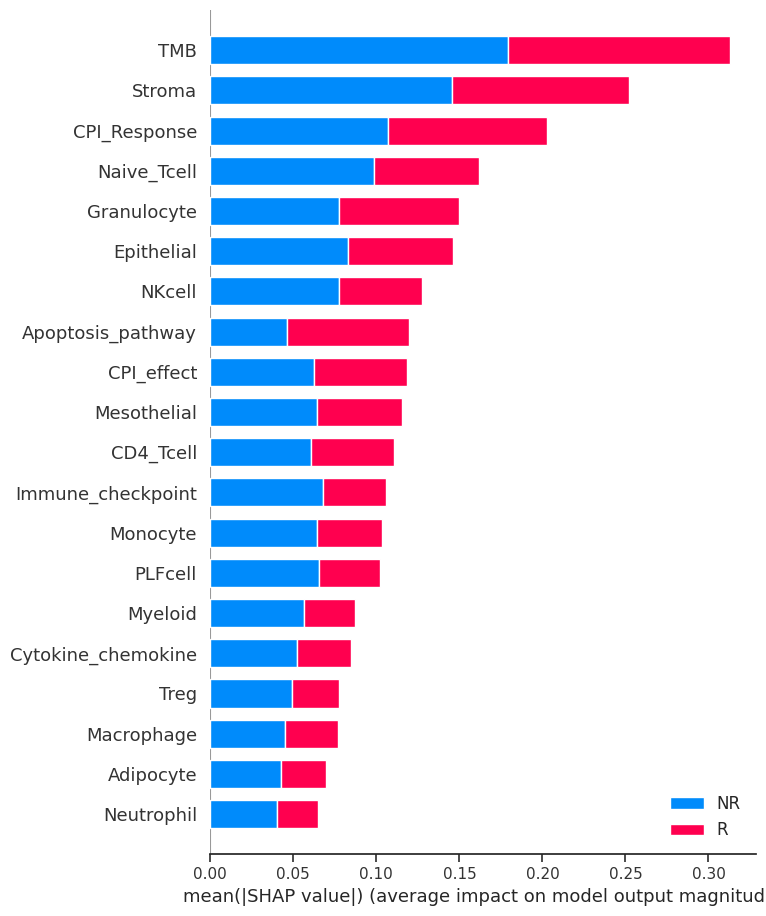

In [15]:
shap.summary_plot(shap_values, x.numpy(), feature_names = fname, class_names = {0:'NR', 1:'R'})

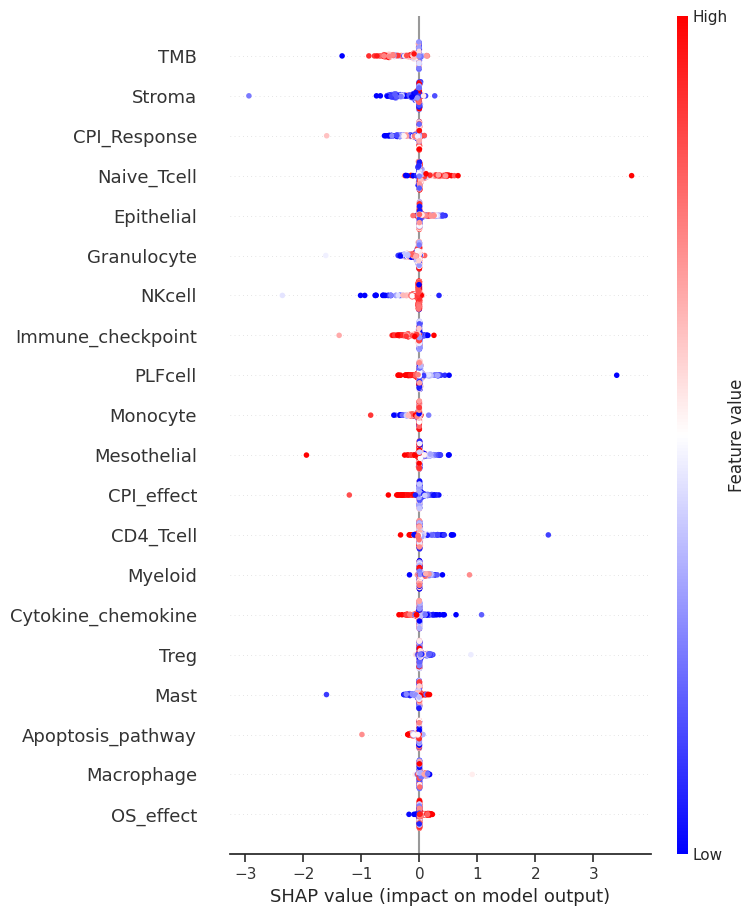

In [16]:
shap.summary_plot(shap_values[0], x.numpy(), feature_names = fname, cmap='bwr', plot_type='dot', class_names = {0:'NR', 1:'R'})

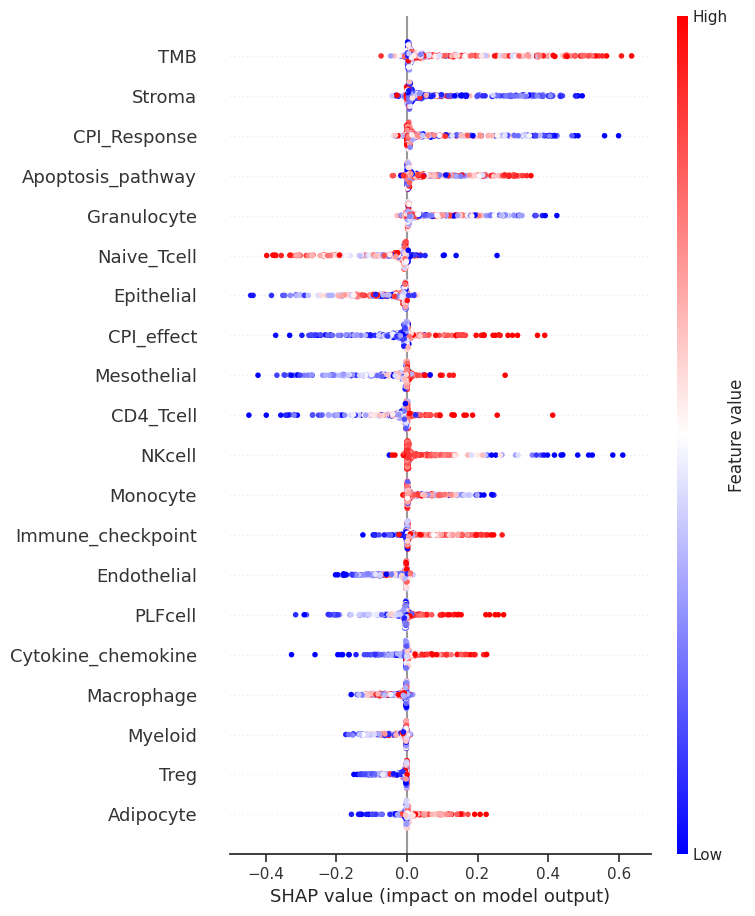

In [17]:
shap.summary_plot(shap_values[1], x.numpy(), feature_names = fname, cmap='bwr', plot_type='dot', class_names = {0:'NR', 1:'R'})

In [18]:
df1 = pd.DataFrame(shap_values[1], columns = fname, index=dfcx.index)
df1.to_csv('shap_fft_r.csv')